In [1]:
import zipline
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
strats = {}
strats["1. Golden Butterfly"] = {
    'SHY': 0.2, 
    'TLT': 0.2, 
    'VTI': 0.2, 
    'IWN': 0.2, 
    'GLD': 0.2
}

strats["2. Rob Armott"] = {
    'BNDX': 0.2, 
    'LQD': 0.2, 
    'VEU': 0.1, 
    'VNQ': 0.1,
    'SPY': 0.1,
    'TLT': 0.1,
    'TIP': 0.1,
    'DBC': 0.1
}

strats["3. Global Asset Allocation"] = {
    'SPY': 0.18, 
    'EFA': 0.135, 
    'EEM': 0.045, 
    'LQD': 0.198,
    'BNDX': 0.144,
    'TLT': 0.135,
    'TIP': 0.018,
    'DBC': 0.05,
    'GLD': 0.05,
    'VNQ': 0.045
}

strats["4. Permanent Portfolio"] = {
    'BIL': 0.25, 
    'GLD': 0.25, 
    'TLT': 0.25, 
    'SPY': 0.25 
}

strats["5. Desert Portfolio"] = {
    'IEF': 0.6, 
    'VTI': 0.3, 
    'GLD': 0.1
}

strats["6. Larry Portfolio"] = {
    'IWN': 0.15, 
    'DLS': 0.075, 
    'EEM': 0.075, 
    'IEF': 0.7 
}

strats["7. Big Rocks Portfolio"] = {
    'AGG': 0.6, 
    'SPY': 0.06, 
    'IWD': 0.06, 
    'IWM': 0.06, 
    'IWN': 0.06, 
    'EFV': 0.04, 
    'VNQ': 0.04, 
    'EFA': 0.02, 
    'SCZ': 0.02, 
    'DLS': 0.02, 
    'EEM': 0.02 
}

strats["8. Sandwich Portfolio"] = {
    'IEF': 0.41, 
    'SPY': 0.2, 
    'SCZ': 0.1, 
    'IWM': 0.08, 
    'EEM': 0.06, 
    'EFA': 0.06, 
    'VNQ': 0.05, 
    'BIL': 0.04
}

strats["9. Balanced Tax Aware Portfolio"] = {
    'AGG': 0.38, 
    'SPY': 0.15, 
    'BIL': 0.15, 
    'EFA': 0.13, 
    'IWM': 0.05,
    'VNQ': 0.05, 
    'DBC': 0.05, 
    'EEM': 0.04
}

strats["10. Balanced Portfolio"] = {
    'AGG': 0.33, 
    'SPY': 0.15, 
    'BIL': 0.15, 
    'EFA': 0.13, 
    'IWM': 0.05,
    'VNQ': 0.05, 
    'DBC': 0.05, 
    'EEM': 0.04, 
    'TIP': 0.02, 
    'BNDX': 0.02, 
    'HYG': 0.01 
}

In [3]:
import numpy as np
import pandas as pd
import sys

sys.path.insert(1,"C:/Users/User/OneDrive/Documents/Finance/Quant/Zipline/Helper_Functions")

import helper
from zipline.data import bundles
from trading_calendars import get_calendar
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline.domain import US_EQUITIES


bundle_name = "MultiAsset_YAHOO"
domain = US_EQUITIES

ingest_func = bundles.csvdir.csvdir_equities(['daily'], bundle_name)
bundles.register(bundle_name, ingest_func)

bundle_data = bundles.load(bundle_name)
engine = helper.build_pipeline_engine(bundle_data, domain)

In [4]:
universe_start_date = bundle_data.equity_daily_bar_reader.first_trading_day
universe_end_date = pd.Timestamp('2022-07-20', tz='UTC')

universe = AverageDollarVolume(window_length=1).top(100) 

universe_tickers = engine.run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
print(universe_tickers)

[Equity(0 [AGG]), Equity(1 [BIL]), Equity(2 [BNDX]), Equity(3 [DBC]), Equity(4 [DLS]), Equity(5 [EEM]), Equity(6 [EFA]), Equity(7 [EFV]), Equity(8 [GLD]), Equity(9 [HYG]), Equity(10 [IEF]), Equity(11 [IWD]), Equity(12 [IWM]), Equity(13 [IWN]), Equity(14 [LQD]), Equity(15 [SCZ]), Equity(16 [SHY]), Equity(17 [SPY]), Equity(18 [TIP]), Equity(19 [TLT]), Equity(20 [VEU]), Equity(21 [VNQ]), Equity(22 [VTI])]


In [5]:
from zipline.data.data_portal import DataPortal
from trading_calendars import get_calendar
trading_calendar = get_calendar('XNYS')

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

closes = get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_start_date,
        universe_end_date)
#Change closes columns from zipline tickers to normal tickers
closes.columns = [closes.columns.values[k].symbol for k in range(len(closes.columns.values))]
print(closes.head())

                           AGG  BIL  BNDX  DBC  DLS  EEM  EFA  EFV  GLD  HYG  \
1993-02-01 00:00:00+00:00  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1993-02-02 00:00:00+00:00  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1993-02-03 00:00:00+00:00  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1993-02-04 00:00:00+00:00  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1993-02-05 00:00:00+00:00  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                           ...  IWN  LQD  SCZ  SHY     SPY  TIP  TLT  VEU  \
1993-02-01 00:00:00+00:00  ...  NaN  NaN  NaN  NaN  44.250  NaN  NaN  NaN   
1993-02-02 00:00:00+00:00  ...  NaN  NaN  NaN  NaN  44.344  NaN  NaN  NaN   
1993-02-03 00:00:00+00:00  ...  NaN  NaN  NaN  NaN  44.812  NaN  NaN  NaN   
1993-02-04 00:00:00+00:00  ...  NaN  NaN  NaN  NaN  45.000  NaN  NaN  NaN   
1993-02-05 00:00:00+00:00  ...  NaN  NaN  NaN  NaN  44.969  NaN  NaN  NaN   

                           VNQ  VTI  
1993-02-01 00:00:0

In [6]:
def initialize(context):
    # Set strategy allocation
    context.securities = strat

    # Schedule rebalance for once a month at the start of the month at market open
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())
    
def rebalance(context, data):
    # Loop through the securities
    for ticker, weight in context.securities.items():
        sym = symbol(ticker)
        # Check if we can trade
        if data.can_trade(sym):
            # Reset the weight
            order_target_percent(sym, weight)

In [7]:
# Create dict to save results to
results = {}
for strat_name, strat in strats.items():
    symbols = list(strat.keys())
    print(strat_name)
    print("======")
    print(symbols)
    #Identify dates for which we have data for all ETFs    
    day_data_complete = np.all(~pd.isnull(closes[symbols]), axis = 1)
    start_index = closes.index[np.where(day_data_complete == True)[0][0]]
    end_index = closes.index[np.where(day_data_complete == True)[0][-1]]
    complete_days = day_data_complete[start_index:end_index].sum()
    print(str(complete_days)+
                "/"+
                str(len(day_data_complete[start_index:end_index]))+
                " days of complete data")
    
    # Check strat sums to 1:
    print("Allocation sums to: "+str(sum(strat.values())))

    # Run Backtest:
    result = zipline.run_algorithm(
                        start=start_index, # Set start
                        end=end_index,  # Set end
                        initialize=initialize, # Define startup function
                        capital_base=100000, # Set initial capital
                        data_frequency = 'daily',  # Set data frequency
                        bundle=bundle_name) # Select bundle
    print("Backtest Complete")
    # Save results to dict:
    results[strat_name] = result

1. Golden Butterfly
['SHY', 'TLT', 'VTI', 'IWN', 'GLD']
4448/4448 days of complete data
Allocation sums to: 1.0


C:\Users\User/.zipline\extension.py:8: UserWarning: Overwriting bundle with name 'MultiAsset_YAHOO'
  register('MultiAsset_YAHOO',MultiAsset.MultiAsset_YAHOO, calendar_name = 'XNYS')
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Backtest Complete
2. Rob Armott
['BNDX', 'LQD', 'VEU', 'VNQ', 'SPY', 'TLT', 'TIP', 'DBC']
2300/2300 days of complete data
Allocation sums to: 0.9999999999999999


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Backtest Complete
3. Global Asset Allocation
['SPY', 'EFA', 'EEM', 'LQD', 'BNDX', 'TLT', 'TIP', 'DBC', 'GLD', 'VNQ']
2300/2300 days of complete data
Allocation sums to: 1.0000000000000002


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Backtest Complete
4. Permanent Portfolio
['BIL', 'GLD', 'TLT', 'SPY']
3814/3814 days of complete data
Allocation sums to: 1.0


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


Backtest Complete
5. Desert Portfolio
['IEF', 'VTI', 'GLD']
4448/4448 days of complete data
Allocation sums to: 0.9999999999999999


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


Backtest Complete
6. Larry Portfolio
['IWN', 'DLS', 'EEM', 'IEF']
4052/4052 days of complete data
Allocation sums to: 1.0


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Backtest Complete
7. Big Rocks Portfolio
['AGG', 'SPY', 'IWD', 'IWM', 'IWN', 'EFV', 'VNQ', 'EFA', 'SCZ', 'DLS', 'EEM']
3677/3677 days of complete data
Allocation sums to: 1.0000000000000002


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


Backtest Complete
8. Sandwich Portfolio
['IEF', 'SPY', 'SCZ', 'IWM', 'EEM', 'EFA', 'VNQ', 'BIL']
3677/3677 days of complete data
Allocation sums to: 1.0


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Backtest Complete
9. Balanced Tax Aware Portfolio
['AGG', 'SPY', 'BIL', 'EFA', 'IWM', 'VNQ', 'DBC', 'EEM']
3814/3814 days of complete data
Allocation sums to: 1.0000000000000002


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Backtest Complete
10. Balanced Portfolio
['AGG', 'SPY', 'BIL', 'EFA', 'IWM', 'VNQ', 'DBC', 'EEM', 'TIP', 'BNDX', 'HYG']
2300/2300 days of complete data
Allocation sums to: 1.0000000000000002


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


Backtest Complete


In [8]:
def reshape_bench(result):
    bench_series = closes["SPY"].pct_change().fillna(0)
    result.index = result.index.normalize() # to set the time to 00:00:00
    bench_series = bench_series[bench_series.index.isin(result.index)]
    return bench_series

In [9]:
# Save results to pandas dataframe
import pyfolio as pf
def analyse(perfdata, bench_returns):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perfdata)
    return pf.timeseries.perf_stats(returns, bench_returns)
    
for strat_name, result in results.items():
    bench_series = reshape_bench(result)
    summ_output = pd.Series(analyse(result, bench_series),
                            name = strat_name)
    if strat_name == list(results.keys())[0]:
        summary = pd.DataFrame(summ_output)
    else:
        summary[strat_name] = summ_output

summary.round(2)

,1. Golden Butterfly,2. Rob Armott,3. Global Asset Allocation,4. Permanent Portfolio,5. Desert Portfolio,6. Larry Portfolio,7. Big Rocks Portfolio,8. Sandwich Portfolio,9. Balanced Tax Aware Portfolio,10. Balanced Portfolio
Annual return,0.05,0.02,0.03,0.04,0.04,0.03,0.02,0.03,0.02,0.02
Cumulative returns,1.44,0.20,0.29,0.90,1.02,0.53,0.32,0.58,0.30,0.24
Annual volatility,0.09,0.07,0.08,0.07,0.06,0.07,0.09,0.11,0.10,0.08
Sharpe ratio,0.61,0.32,0.40,0.64,0.68,0.43,0.25,0.34,0.23,0.35
Calmar ratio,0.23,0.11,0.15,0.26,0.25,0.15,0.07,0.09,0.05,0.13
Stability,0.96,0.76,0.83,0.93,0.97,0.92,0.89,0.92,0.82,0.78
Max drawdown,-0.22,-0.18,-0.19,-0.16,-0.16,-0.18,-0.29,-0.34,-0.33,-0.18
Omega ratio,1.12,1.06,1.08,1.12,1.13,1.08,1.05,1.07,1.05,1.07
Sortino ratio,0.86,0.43,0.53,0.89,0.97,0.61,0.35,0.47,0.31,0.46
Skew,-0.38,-1.71,-1.47,-0.28,-0.21,-0.21,-0.41,-0.29,-0.21,-1.52


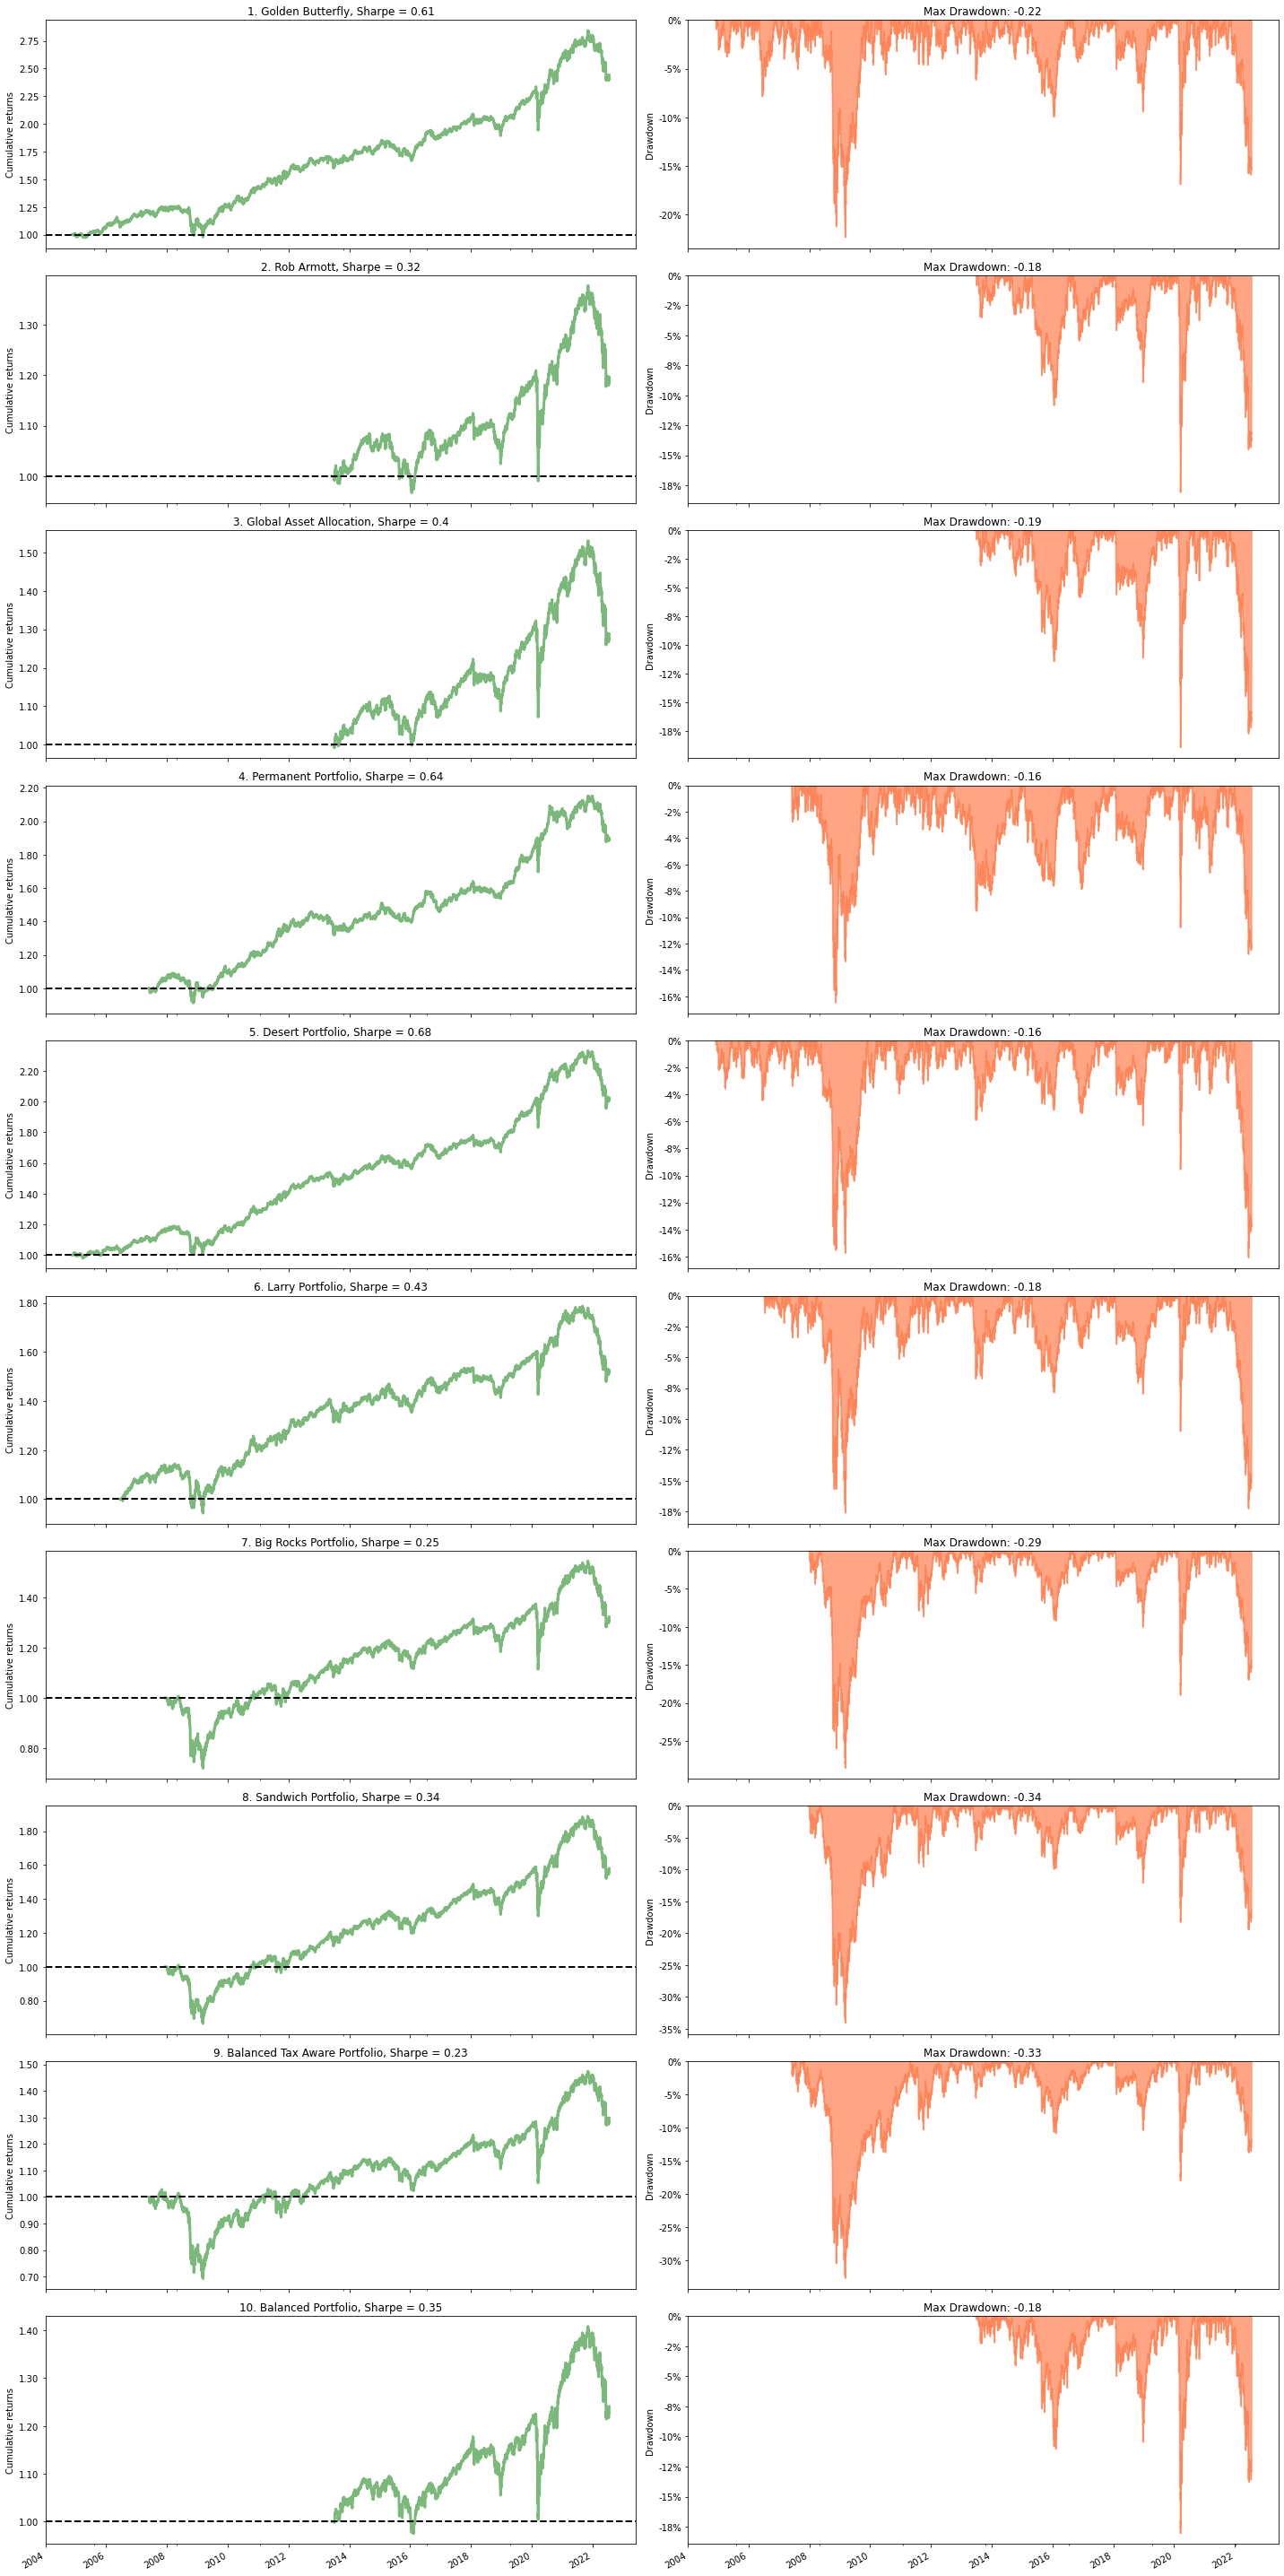

In [10]:
from matplotlib import ticker

# Make a figure
fig, ax = plt.subplots(nrows = len(results.items()),
                        ncols = 2, 
                        sharex=True, 
                        sharey=False,
                        figsize=(20, 40))
k = 0
for strat_name, result in results.items():
    k += 1
    df = result.copy().filter(items=['portfolio_value'])
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)           
    pf.plot_rolling_returns(returns,ax=ax[k-1,0])
    ax[k-1,0].set_title(strat_name+", Sharpe = "+str(summary.loc["Sharpe ratio",(strat_name)].round(2)))
    ax[k-1,0].get_legend().remove()
    pf.plot_drawdown_underwater(returns, ax=ax[k-1,1])
    ax[k-1,1].set_title("Max Drawdown: "+str(summary.loc["Max drawdown",(strat_name)].round(2)))
    plt.tight_layout()